In [1]:
from fastai.tabular.all import *
from fastai.collab import *
import pandas as pd


In [2]:
path= untar_data(URLs.ML_100k)

In [3]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()


,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [5]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


In [6]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [7]:
dls.show_batch()

,user,title,rating
0,586,Batman Forever (1995),5
1,580,Star Wars (1977),5
2,806,Batman (1989),4
3,454,Evita (1996),3
4,476,Young Guns (1988),3
5,527,"Piano, The (1993)",2
6,458,"Sting, The (1973)",2
7,373,My Fair Lady (1964),4
8,938,Heat (1995),5
9,25,Fantasia (1940),2


In [8]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.882672,0.958232,00:09
1,0.667119,0.902196,00:09
2,0.549656,0.871543,00:09
3,0.452668,0.858609,00:09
4,0.417910,0.854556,00:09


In [9]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

In [10]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [11]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [12]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3253), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2931), 'Stuart Saves His Family (1995)', 2.125),
 (tensor(-0.2904), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2851), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2694), 'Halloween: The Curse of Michael Myers (1995)', 2.2),
 (tensor(-0.2542), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2489),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2436), 'Hellraiser: Bloodline (1996)', 2.0),
 (tensor(-0.2403),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2382), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2357), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2336), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2192), 'Sgt. Bilko (1996)', 2.5675675675675675),
 (tensor(-0.2192), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2094), "Joe's Apartment (1996)", 2.24444444

In [13]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5570), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5554), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5540), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5073), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5028), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.5022), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5017), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4975), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4932), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4882), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4874), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4825), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4759), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4487),
  'Wallace & Gromit: The Best of Aardman Animation (1996)',
  4.447761194029851),
 (tensor(0.4337), 'Fugitive, The (1993)', 4.044642857142857)]

In [14]:
#Movie Weights
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

In [15]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [16]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [17]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2872), 'Jungle2Jungle (1997)'),
 (tensor(1.1225), 'Home Alone 3 (1997)'),
 (tensor(1.1182), 'Leave It to Beaver (1997)'),
 (tensor(1.0982), 'Bio-Dome (1996)'),
 (tensor(1.0791), 'Beautician and the Beast, The (1997)'),
 (tensor(1.0756), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.0722), 'Congo (1995)'),
 (tensor(1.0508), 'Flipper (1996)'),
 (tensor(1.0279), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.0261), 'Turbulence (1997)')]

In [18]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1605), 'Casablanca (1942)'),
 (tensor(-1.0999), 'Godfather, The (1972)'),
 (tensor(-1.0925), 'Third Man, The (1949)'),
 (tensor(-1.0661), 'Chinatown (1974)'),
 (tensor(-1.0621), 'Apocalypse Now (1979)'),
 (tensor(-1.0589), 'Citizen Kane (1941)'),
 (tensor(-1.0399), 'Lawrence of Arabia (1962)'),
 (tensor(-1.0396), 'Close Shave, A (1995)'),
 (tensor(-0.9980), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(-0.9887), 'Top Hat (1935)')]

In [19]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [20]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2019), 'Braveheart (1995)'),
 (tensor(0.9420), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9367), "It's a Wonderful Life (1946)"),
 (tensor(0.9360), 'Titanic (1997)'),
 (tensor(0.9280), 'Star Wars (1977)'),
 (tensor(0.8905), 'Independence Day (ID4) (1996)'),
 (tensor(0.8661), 'Hunt for Red October, The (1990)'),
 (tensor(0.8448), 'Forrest Gump (1994)'),
 (tensor(0.8215), 'Pretty Woman (1990)'),
 (tensor(0.8152), 'Aladdin (1992)')]

In [21]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8815), 'Trainspotting (1996)'),
 (tensor(-0.8732), 'Road to Wellville, The (1994)'),
 (tensor(-0.8316), 'Keys to Tulsa (1997)'),
 (tensor(-0.8112), 'Cook the Thief His Wife & Her Lover, The (1989)'),
 (tensor(-0.8055), 'Cable Guy, The (1996)'),
 (tensor(-0.7905), 'Stupids, The (1996)'),
 (tensor(-0.7883), 'Jude (1996)'),
 (tensor(-0.7820), 'Lost Highway (1997)'),
 (tensor(-0.7371), 'Showgirls (1995)'),
 (tensor(-0.7262), 'Barb Wire (1996)')]

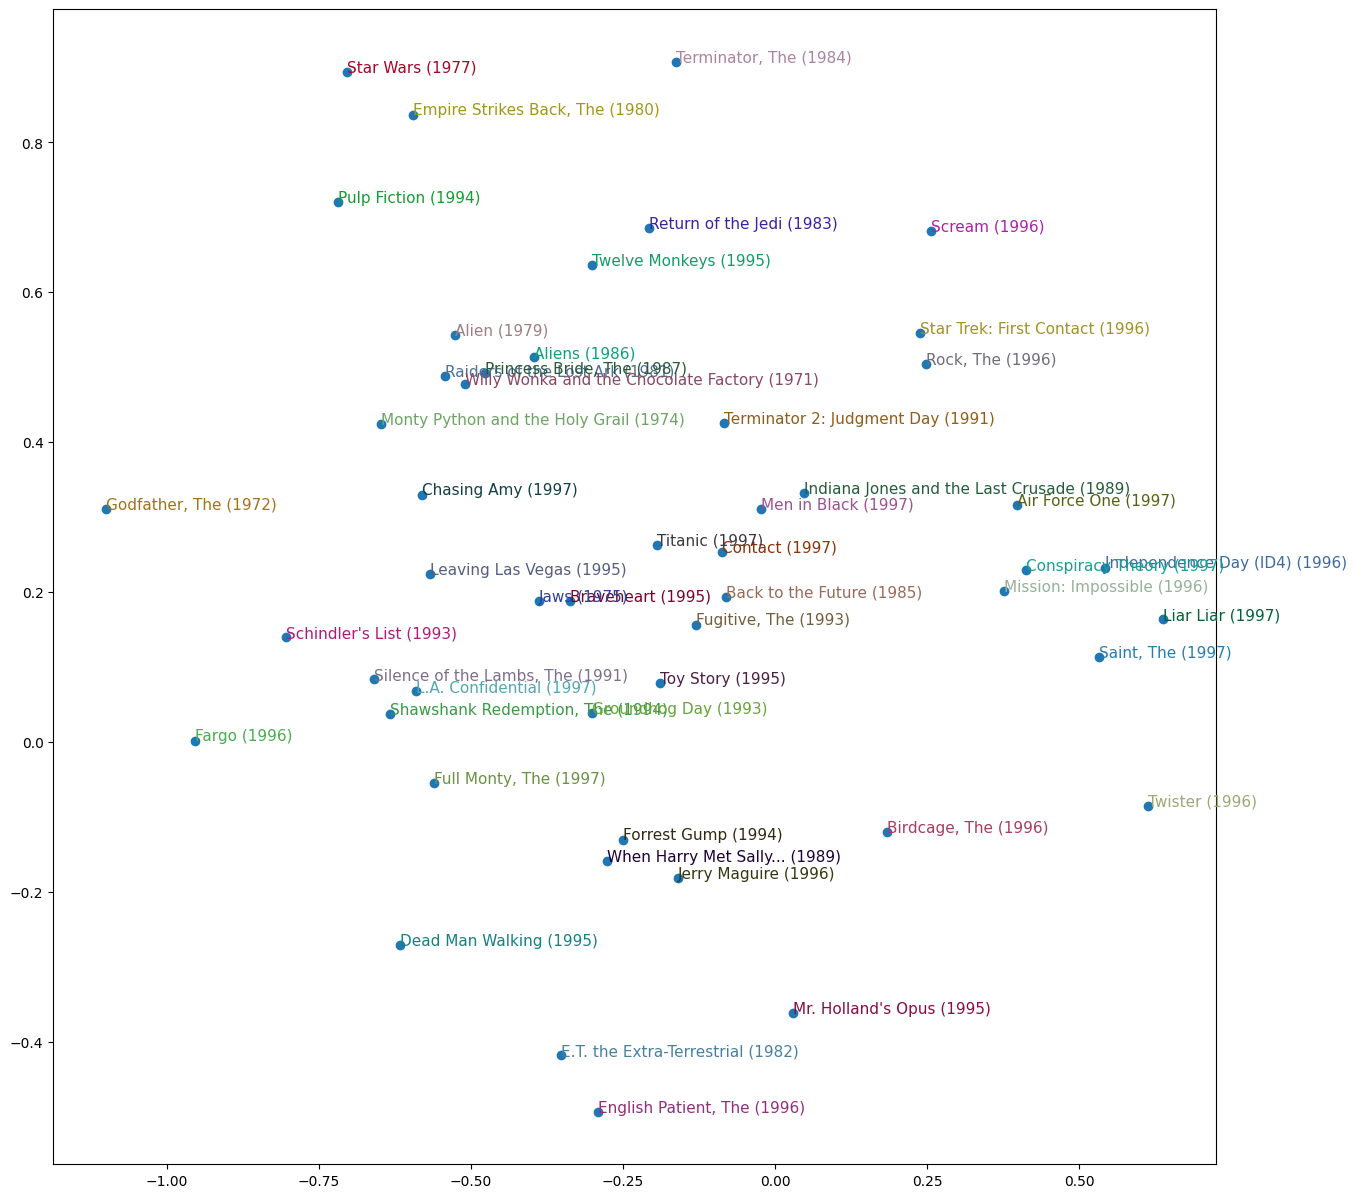

In [22]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()